In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [2]:
!pwd

/Users/josephbarry/Desktop/FinTech_Class/3rd_Project/FinTech_Portfolio_Dash/JGB_Notebook


In [3]:
csvpath = Path("TSM.csv")

df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-08-16,11.49,11.68,11.40,11.52,8.523615,11531700
2011-08-17,11.54,11.59,11.35,11.51,8.516215,10491600
2011-08-18,11.15,11.21,10.75,11.05,8.175861,21118100
2011-08-19,10.94,11.22,10.90,10.94,8.094472,11898100
2011-08-22,11.21,11.31,11.04,11.24,8.316442,17618100


In [4]:
df = df[['Close']]
df

,Close
Date,
2011-08-16,11.520000
2011-08-17,11.510000
2011-08-18,11.050000
2011-08-19,10.940000
2011-08-22,11.240000
...,...
2021-08-09,118.220001
2021-08-10,116.360001
2021-08-11,115.989998


In [5]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window- 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
window_size = 100
feature_column = 0 # why 0?
target_column = 0 # Why 0?

X, y = window_data(df, window_size, feature_column, target_column)

print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[11.52 11.51 11.05 10.94 11.24 11.84 11.74 11.35 11.81 12.13 11.97 11.97
  11.89 11.66 11.52 12.05 12.   11.88 11.94 11.96 11.82 12.11 12.41 12.22
  12.12 11.92 11.52 11.71 11.56 12.02 11.77 11.81 11.43 11.31 11.74 11.82
  11.83 11.8  12.02 11.86 12.16 12.17 12.3  12.01 12.21 12.11 11.81 12.18
  12.48 12.19 12.25 12.95 12.74 12.62 12.45 12.72 12.9  12.98 13.   12.93
  12.48 12.67 12.95 12.98 13.08 12.74 12.71 12.66 12.56 12.56 12.2  12.07
  12.55 12.4  12.92 13.21 13.12 13.22 12.94 13.22 12.94 13.08 12.93 12.72
  12.55 12.5  12.76 12.32 12.66 12.71 12.91 12.92 13.02 12.92 13.02 12.91
  13.26 13.14 13.26 13.15]
 [11.51 11.05 10.94 11.24 11.84 11.74 11.35 11.81 12.13 11.97 11.97 11.89
  11.66 11.52 12.05 12.   11.88 11.94 11.96 11.82 12.11 12.41 12.22 12.12
  11.92 11.52 11.71 11.56 12.02 11.77 11.81 11.43 11.31 11.74 11.82 11.83
  11.8  12.02 11.86 12.16 12.17 12.3  12.01 12.21 12.11 11.81 12.18 12.48
  12.19 12.25 12.95 12.74 12.62 12.45 12.72 12.9  12.98 13.   12.93 

In [7]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [8]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
#x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
#y_test_scaler = MinMaxScaler()

# Fit the scaler for the training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the testing Data
#x_test_scaler.fit(X_test)
#y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [9]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = window_size
# 20% of neurons to be dropped out
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [12]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [13]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
15/15 [==============================] - 1s 77ms/step - loss: 0.0052
Epoch 2/20
15/15 [==============================] - 1s 77ms/step - loss: 0.0131
Epoch 3/20
15/15 [==============================] - 1s 75ms/step - loss: 0.0150
Epoch 4/20
15/15 [==============================] - 1s 78ms/step - loss: 0.0175
Epoch 5/20
15/15 [==============================] - 1s 87ms/step - loss: 0.0143
Epoch 6/20
15/15 [==============================] - 1s 77ms/step - loss: 0.0213
Epoch 7/20
15/15 [==============================] - 1s 75ms/step - loss: 0.0114
Epoch 8/20
15/15 [==============================] - 1s 72ms/step - loss: 0.0079
Epoch 9/20
15/15 [==============================] - 1s 72ms/step - loss: 0.0065
Epoch 10/20
15/15 [==============================] - 1s 71ms/step - loss: 0.0219
Epoch 11/20
15/15 [==============================] - 1s 72ms/step - loss: 0.0094
Epoch 12/20
15/15 [==============================] - 1s 71ms/step - loss: 0.0064
Epoch 13/20
15/15 [==================

In [14]:
model.evaluate(X_test, y_test, verbose=0)

0.6233460307121277

In [15]:
predicted = model.predict(X_test)

In [16]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [17]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [18]:
actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 

# Show the DataFrame's head
actual_predicted.head()

,Actual,Predicted
Date,,
2017-10-12,40.349998,37.119484
2017-10-13,40.439999,37.288998
2017-10-16,40.820000,37.506630
2017-10-17,40.889999,37.767639
2017-10-18,41.250000,38.057526


In [19]:
actual_predicted.tail()

,Actual,Predicted
Date,,
2021-08-09,118.209999,72.348686
2021-08-10,118.220001,72.374352
2021-08-11,116.360001,72.398895
2021-08-12,115.989998,72.410446
2021-08-13,115.699997,72.409721


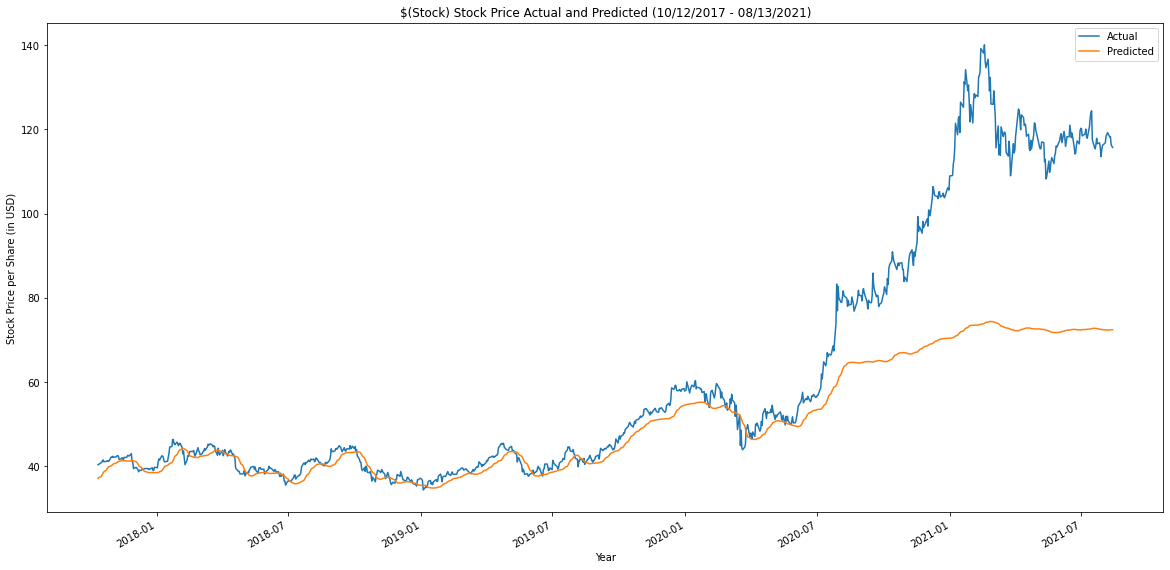

In [20]:
actual_predicted.plot(figsize=(20,10))
plt.title('$(Stock) Stock Price Actual and Predicted (10/12/2017 - 08/13/2021)')
plt.xlabel('Year')
plt.ylabel('Stock Price per Share (in USD)')
plt.legend(loc="best")
plt.show()